In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [33]:
# Load dataset
df = pd.read_excel("loan_dataset.xlsx")
print("Dataset shape:", df.shape)
#print(df.head())

# Check data types and missing values
print(df.info())
print(df.isna().sum())


Dataset shape: (255246, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255246 entries, 0 to 255245
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255246 non-null  object 
 1   Age             255246 non-null  int64  
 2   Income          255246 non-null  int64  
 3   LoanAmount      255246 non-null  int64  
 4   CreditScore     255246 non-null  int64  
 5   MonthsEmployed  255246 non-null  int64  
 6   NumCreditLines  255246 non-null  int64  
 7   InterestRate    255246 non-null  float64
 8   LoanTerm        255246 non-null  int64  
 9   DTIRatio        255246 non-null  float64
 10  Education       255246 non-null  object 
 11  EmploymentType  255246 non-null  object 
 12  MaritalStatus   255246 non-null  object 
 13  HasMortgage     255246 non-null  object 
 14  HasDependents   255246 non-null  object 
 15  LoanPurpose     255246 non-null  object 
 16  HasCoSigner     255246 non-n

In [35]:
# Drop irrelevant column
X = df.drop(['LoanID', 'Default'], axis=1)
y = df['Default']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical features: ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [37]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (204196, 16)
Test shape: (51050, 16)


In [39]:
# Income to Loan Amount ratio
X_train['Income_to_LoanRatio'] = X_train['Income'] / (X_train['LoanAmount'] + 1)
X_test['Income_to_LoanRatio'] = X_test['Income'] / (X_test['LoanAmount'] + 1)

# Age groups (older borrowers usually default less)
X_train['AgeGroup'] = pd.cut(X_train['Age'], bins=[18,30,45,60,100], labels=['18-30','31-45','46-60','60+'])
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=[18,30,45,60,100], labels=['18-30','31-45','46-60','60+'])

# Credit Score Categories
def credit_category(score):
    if score >= 800: return 'Excellent'
    elif score >= 740: return 'Very Good'
    elif score >= 670: return 'Good'
    elif score >= 580: return 'Fair'
    else: return 'Poor'

X_train['CreditScoreCategory'] = X_train['CreditScore'].apply(credit_category)
X_test['CreditScoreCategory'] = X_test['CreditScore'].apply(credit_category)


In [41]:
# Cap extreme values at 1st and 99th percentiles
for col in ['Income', 'LoanAmount', 'CreditScore', 'InterestRate', 'DTIRatio']:
    lower = X_train[col].quantile(0.01)
    upper = X_train[col].quantile(0.99)
    X_train[col] = np.clip(X_train[col], lower, upper)
    X_test[col] = np.clip(X_test[col], lower, upper)


In [43]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Update numeric and categorical lists
numeric_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Income_to_LoanRatio']
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 
                        'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 
                        'AgeGroup', 'CreditScoreCategory']

# Pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Default
0    180481
1     23715
Name: count, dtype: int64


/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/2479962886.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_counts.index, y=default_counts.values, palette="Set2")


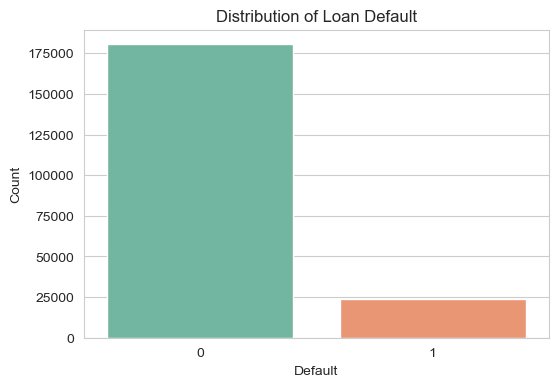

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

# Default counts
default_counts = y_train.value_counts()
print(default_counts)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=default_counts.index, y=default_counts.values, palette="Set2")
plt.title("Distribution of Loan Default")
plt.xlabel("Default")
plt.ylabel("Count")
plt.show()


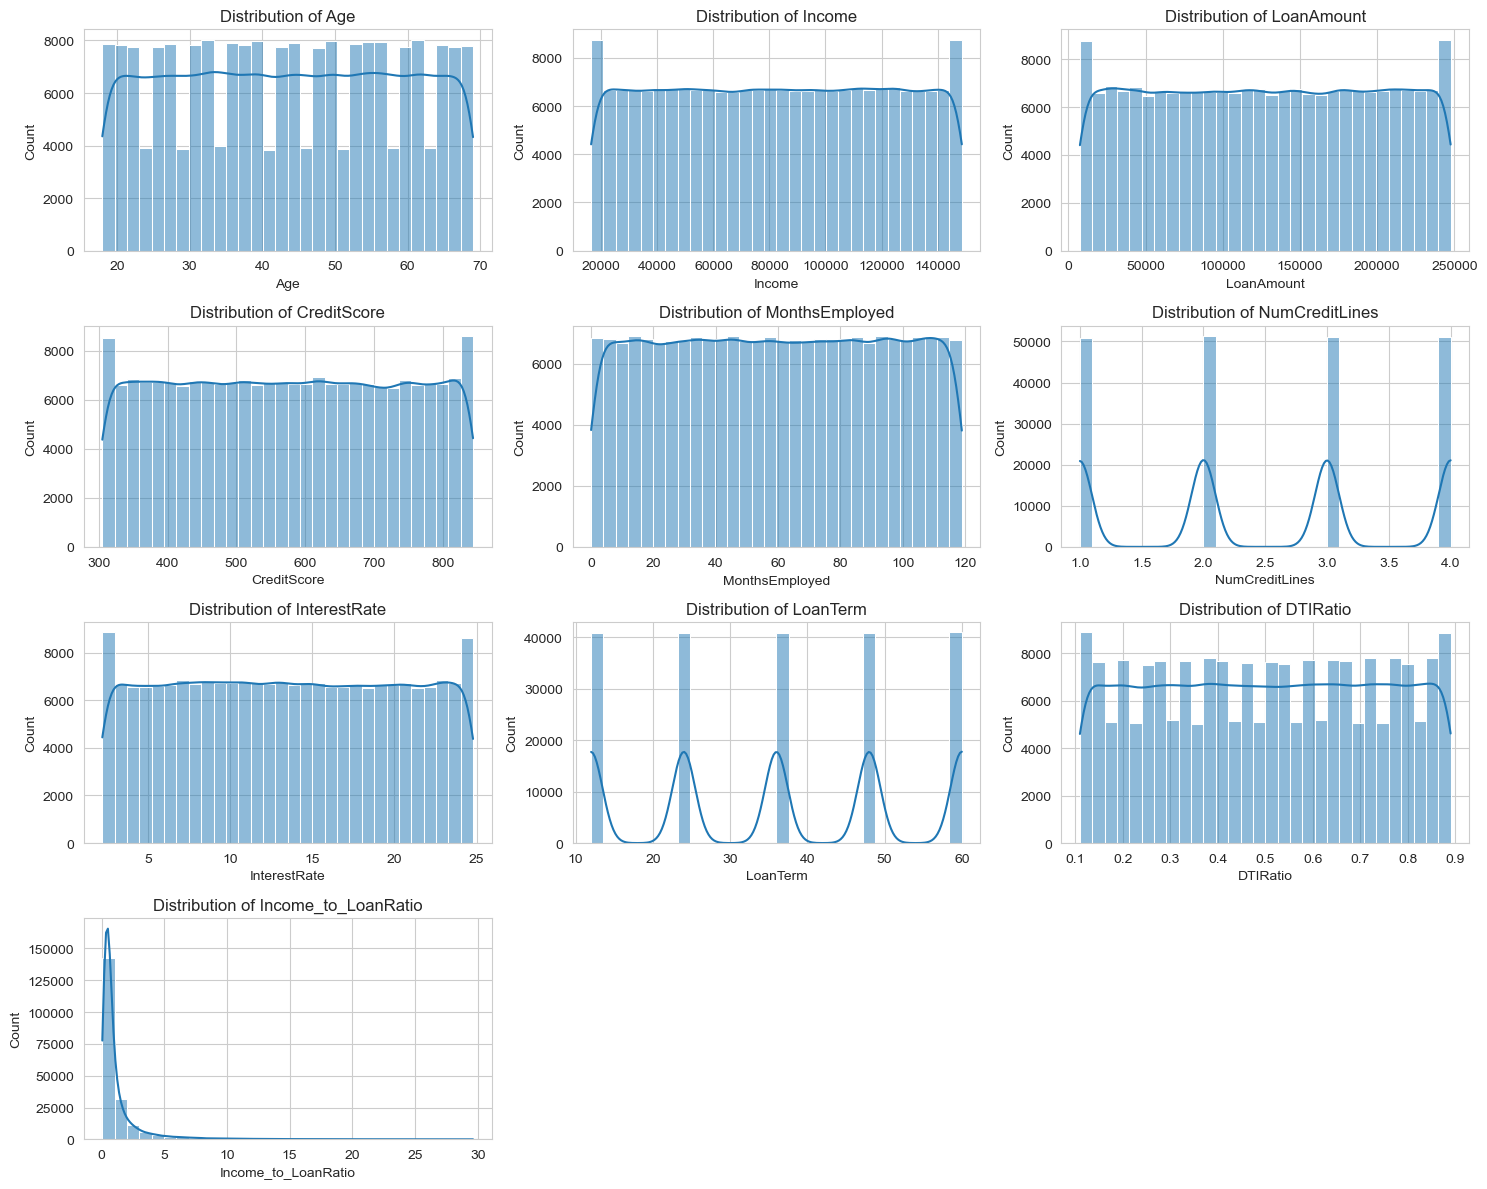

In [51]:
numeric_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Income_to_LoanRatio']

plt.figure(figsize=(15,12))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(4,3,i)
    sns.histplot(X_train[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


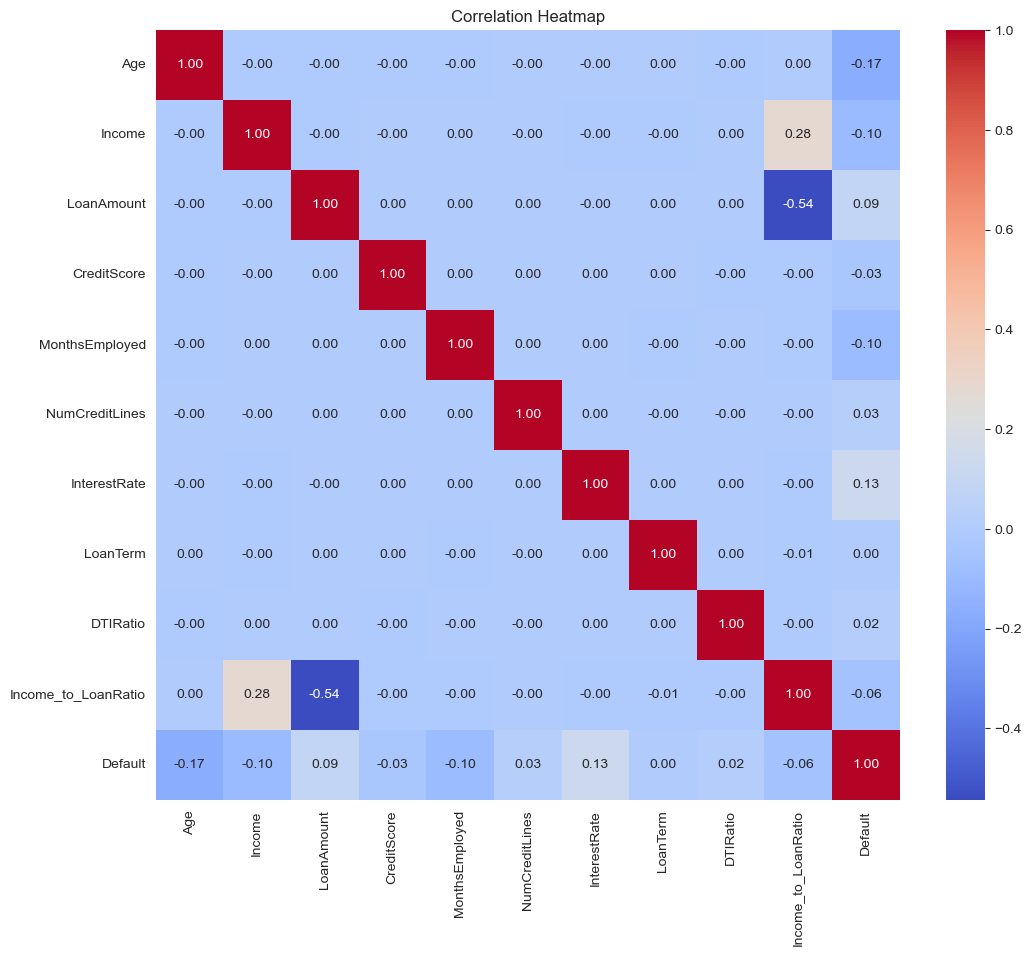

In [53]:
plt.figure(figsize=(12,10))
corr = X_train[numeric_features].join(y_train).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/310117533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y=y_train, data=X_train.join(y_train), palette="Blues")


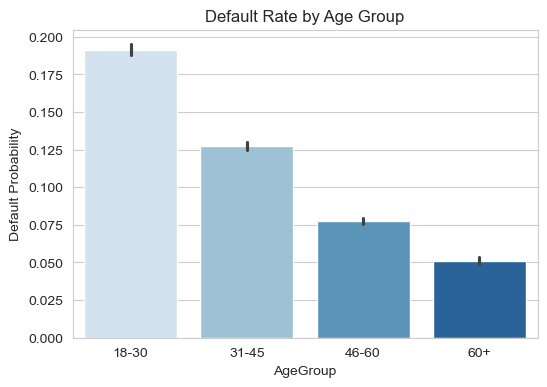

In [55]:
plt.figure(figsize=(6,4))
sns.barplot(x='AgeGroup', y=y_train, data=X_train.join(y_train), palette="Blues")
plt.title("Default Rate by Age Group")
plt.ylabel("Default Probability")
plt.show()


/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/750974385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CreditScoreCategory', y=y_train, data=X_train.join(y_train),


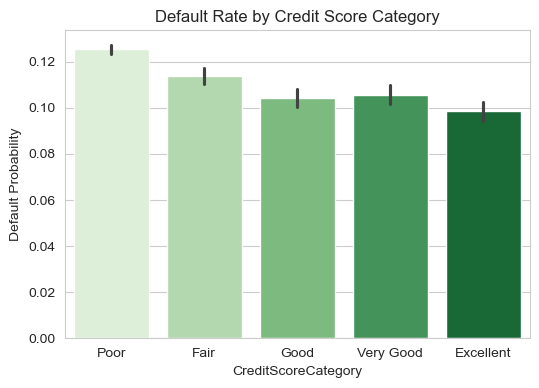

In [57]:
plt.figure(figsize=(6,4))
sns.barplot(x='CreditScoreCategory', y=y_train, data=X_train.join(y_train), 
            order=['Poor','Fair','Good','Very Good','Excellent'], palette="Greens")
plt.title("Default Rate by Credit Score Category")
plt.ylabel("Default Probability")
plt.show()


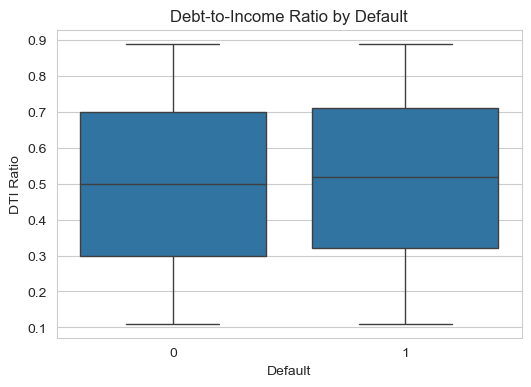

In [59]:
plt.figure(figsize=(6,4))
sns.boxplot(x=y_train, y=X_train['DTIRatio'])
plt.title("Debt-to-Income Ratio by Default")
plt.ylabel("DTI Ratio")
plt.xlabel("Default")
plt.show()

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

In [71]:
# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]

# Evaluation
print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression Report
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45121
           1       0.22      0.70      0.34      5929

    accuracy                           0.68     51050
   macro avg       0.58      0.69      0.56     51050
weighted avg       0.86      0.68      0.74     51050

ROC-AUC Score: 0.7529829024528558


In [73]:
# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42))
])

# Train the model
dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:,1]

# Evaluation
print("Decision Tree Report")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_dt))

Decision Tree Report
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     45121
           1       0.21      0.68      0.32      5929

    accuracy                           0.67     51050
   macro avg       0.58      0.67      0.55     51050
weighted avg       0.86      0.67      0.73     51050

ROC-AUC Score: 0.7300314157981433


<Figure size 600x600 with 0 Axes>

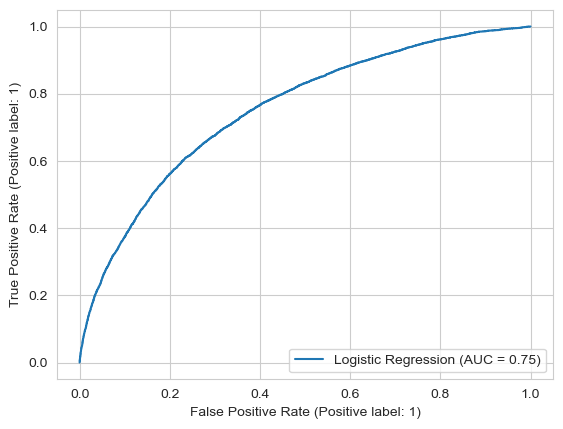

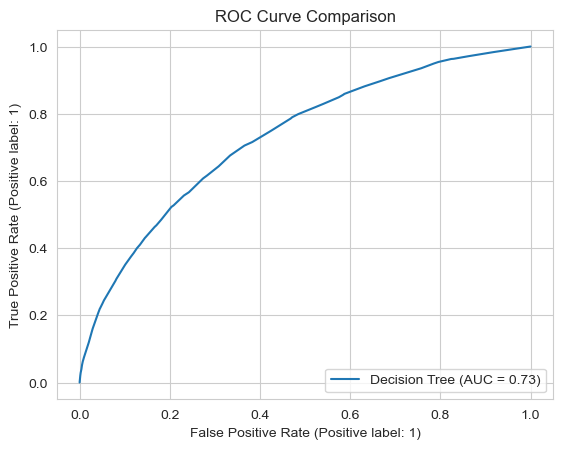

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,6))

RocCurveDisplay.from_estimator(lr_pipeline, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(dt_pipeline, X_test, y_test, name="Decision Tree")

plt.title("ROC Curve Comparison")
plt.show()

/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/14121545.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="magma")


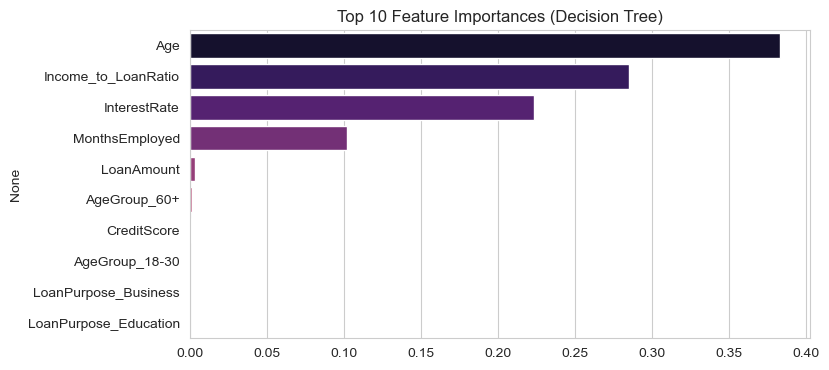

In [77]:
# Extract feature importance from Decision Tree
feature_names = numeric_features + list(dt_pipeline.named_steps['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot'].get_feature_names_out(categorical_features))

importances = dt_pipeline.named_steps['classifier'].feature_importances_

# Sort and display top 10 features
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="magma")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

In [79]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        class_weight='balanced', 
        random_state=42
    ))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score
print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))


Random Forest Report
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     45121
           1       0.24      0.64      0.35      5929

    accuracy                           0.72     51050
   macro avg       0.59      0.68      0.59     51050
weighted avg       0.86      0.72      0.77     51050

ROC-AUC Score: 0.7510454273757681


In [80]:
from xgboost import XGBClassifier

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),  # handle imbalance
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

# Evaluation
print("XGBoost Report")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:26:03] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     45121
           1       0.24      0.65      0.35      5929

    accuracy                           0.72     51050
   macro avg       0.59      0.69      0.58     51050
weighted avg       0.86      0.72      0.76     51050

ROC-AUC Score: 0.753487961077683


<Figure size 600x600 with 0 Axes>

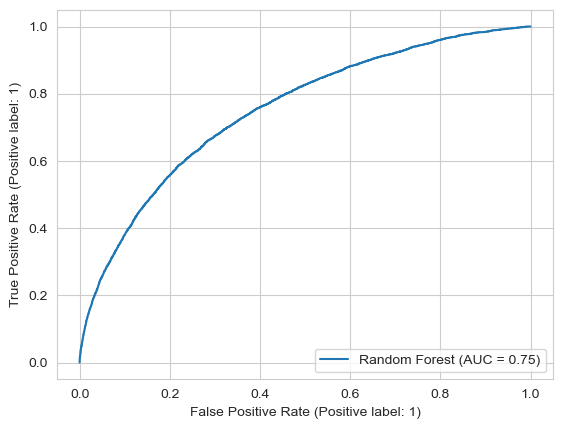

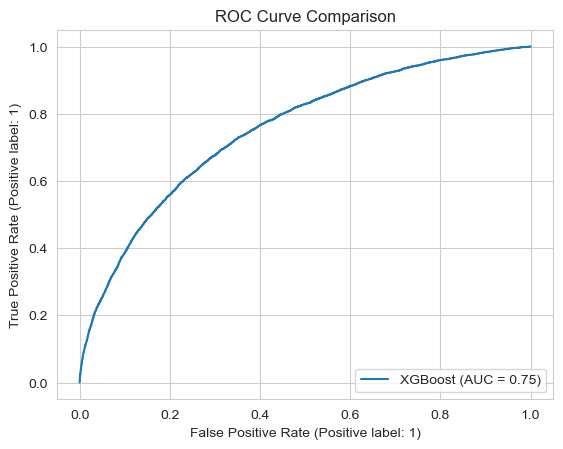

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,6))
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test, name="XGBoost")
plt.title("ROC Curve Comparison")
plt.show()


/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/401180070.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


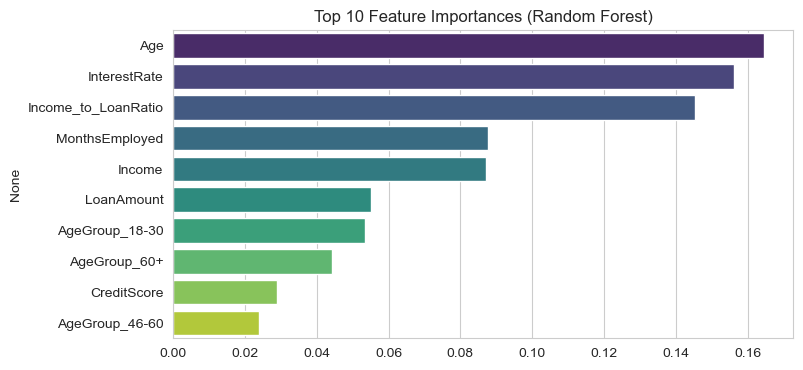

In [85]:
# Feature importance from Random Forest
feature_names = numeric_features + list(rf_pipeline.named_steps['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot'].get_feature_names_out(categorical_features))

importances = rf_pipeline.named_steps['classifier'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [95]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [6, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]

}

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score=0  
)



In [103]:
# Fit randomized search
rf_random_search.fit(X_train, y_train)

# Best parameters and F1-score
print("Best Parameters:", rf_random_search.best_params_)
print("Best F1-score:", rf_random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__max_depth=6, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=  12.3s
[CV] END classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  43.3s
[CV] END classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=  55.2s


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=6, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=  12.2s
[CV] END classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  42.8s
[CV] END classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  42.9s
[CV] END classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=  53.0s
Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 15}
Best F1-score: 0.345003198924753


In [105]:
# Predictions on test set
y_pred_rf_best = rf_random_search.predict(X_test)
y_proba_rf_best = rf_random_search.predict_proba(X_test)[:,1]

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score
print("Tuned Random Forest Report")
print(classification_report(y_test, y_pred_rf_best))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf_best))


Tuned Random Forest Report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     45121
           1       0.32      0.42      0.36      5929

    accuracy                           0.83     51050
   macro avg       0.62      0.65      0.63     51050
weighted avg       0.85      0.83      0.84     51050

ROC-AUC Score: 0.7517990614386252


In [107]:
from sklearn.ensemble import VotingClassifier

# Create Voting Classifier (soft voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_pipeline),                     # Logistic Regression
        ('rf', rf_random_search.best_estimator_), # Tuned Random Forest
        ('xgb', xgb_pipeline)                    # XGBoost
    ],
    voting='soft',  # uses predicted probabilities
    n_jobs=-1
)

# Fit the ensemble
voting_clf.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:01:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time= 1.0min
[CV] END classifier__max_depth=15, classifier__max_features=None, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time= 5.2min


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'Income',
                                                                                 'LoanAmount',
                                                                                 'CreditScore',
                                                                                 'MonthsEmployed',
                                                                                 'NumCreditLines',
                                                                                 'InterestRate',
                                                                                 'LoanTerm',
                                                                                 'DTIRatio',
                                                                                 'Income_to_LoanRatio']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknow...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))]))],
                 n_jobs=-1, voting='soft')

In [109]:
# Predictions on test set
y_pred_ensemble = voting_clf.predict(X_test)
y_proba_ensemble = voting_clf.predict_proba(X_test)[:,1]

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score
print("Voting Classifier Report")
print(classification_report(y_test, y_pred_ensemble))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_ensemble))

Voting Classifier Report
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     45121
           1       0.25      0.61      0.36      5929

    accuracy                           0.75     51050
   macro avg       0.60      0.69      0.60     51050
weighted avg       0.86      0.75      0.79     51050

ROC-AUC Score: 0.7580982645831362


/var/folders/cd/kdv522_d31sblcks5wgyxjcm0000gn/T/ipykernel_9965/3911667090.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="coolwarm")


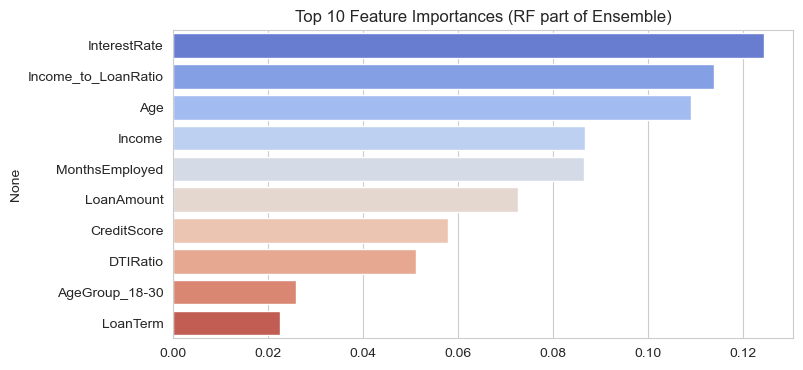

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract numeric + encoded categorical feature names
feature_names = numeric_features + list(
    rf_pipeline.named_steps['preprocessor']
       .named_transformers_['cat']
       .named_steps['onehot'].get_feature_names_out(categorical_features)
)

# Use tuned Random Forest feature importances
importances = rf_random_search.best_estimator_.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

# Plot top 10 features
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="coolwarm")
plt.title("Top 10 Feature Importances (RF part of Ensemble)")
plt.show()

In [167]:
import joblib

# Let's say your trained model is called `best_model`
joblib.dump(voting_clf, 'best_model.pkl')
print("Model saved!")


Model saved!


In [155]:
import shap
import matplotlib.pyplot as plt
import numpy as np
# Add 'Unknown' to the categories
X_train['AgeGroup'] = X_train['AgeGroup'].cat.add_categories('Unknown')
X_test['AgeGroup'] = X_test['AgeGroup'].cat.add_categories('Unknown')

# Fill missing values
X_train['AgeGroup'] = X_train['AgeGroup'].fillna('Unknown')
X_test['AgeGroup'] = X_test['AgeGroup'].fillna('Unknown')



In [161]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
cat_cols = ['Education', 'EmploymentType', 'MaritalStatus', 
            'HasMortgage', 'HasDependents', 'LoanPurpose', 
            'HasCoSigner', 'AgeGroup', 'CreditScoreCategory']

# One-hot encode
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Convert back to DataFrame
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_test.index)

num_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
            'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Income_to_LoanRatio']

X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

# Combine numeric + encoded categorical
X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_enc = pd.concat([X_test_num, X_test_cat], axis=1)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [163]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", pd.Series(y_train_res).value_counts())


Original class distribution:
 Default
0    180481
1     23715
Name: count, dtype: int64
After SMOTE class distribution:
 Default
0    180481
1    180481
Name: count, dtype: int64


In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Instantiate model (can tune later)
rf = RandomForestClassifier(n_estimators=300, max_depth=15, max_features='log2', 
                            min_samples_split=10, min_samples_leaf=4, random_state=42)

# Train on SMOTE data
rf.fit(X_train_res, y_train_res)

# Predict on test data
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# Evaluation
print("Random Forest Report (Balanced Training Data):")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print("\nTop 10 Features:")
print(feature_importance_df.head(10))


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Instantiate base models
lr = LogisticRegression(max_iter=1000, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# Train on SMOTE data
voting_clf.fit(X_train_res, y_train_res)

# Predict
y_pred_vote = voting_clf.predict(X_test)
y_proba_vote = voting_clf.predict_proba(X_test)[:,1]

# Evaluation
print("Voting Classifier Report:")
print(classification_report(y_test, y_pred_vote))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_vote))